----

# Proyecto: Optimización de gastos de marketing para Showz
# Analista: Daniel Ramírez Martínez 
# Fecha: 1 de abril de 2025

## Introducción

Showz es una empresa que busca optimizar sus gastos de marketing analizando datos de usuarios (2017-2018). Este proyecto investiga patrones de comportamiento, conversión a ventas y rentabilidad de canales de adquisición.



## Objetivos 

1. Analizar uso diario del servicio
2. Calcular tiempo de conversión a primera compra
3. Determinar LTV y CAC por fuente
4. Evaluar ROMI de campañas
5. Proporcionar recomendaciones basadas en datos

## Datos utilizados

visits_log_us.csv: Registro de visitas al sitio web (2017-2018).

orders_log_us.csv: Historial de pedidos y revenue.

costs_us.csv: Gastos de marketing por fuente y fecha.

### Preparación de Datos

#### Carga y verificación inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Cargar datos
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

# Verificación básica
print('Visits info:')
visits.info()
print('\nPrimeras filas visits:')
display(visits.head())

Visits info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

Primeras filas visits:


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


#### Transformaciones

In [2]:
# Convertir fechas
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])

# Calcular duración de sesiones
visits['duration'] = (visits['End Ts'] - visits['Start Ts']).dt.total_seconds()

# Eliminar sesiones inválidas
visits = visits[visits['duration'] >= 0]

#### Análisis de las sesiones largas (top 5%) descartables 

Duración máxima total: 11.85 horas
Duración media (total): 10.72 minutos
Umbral del percentil 95: 38.00 minutos
Cantidad de sesiones largas: 17697
Porcentaje de sesiones largas: 4.92%


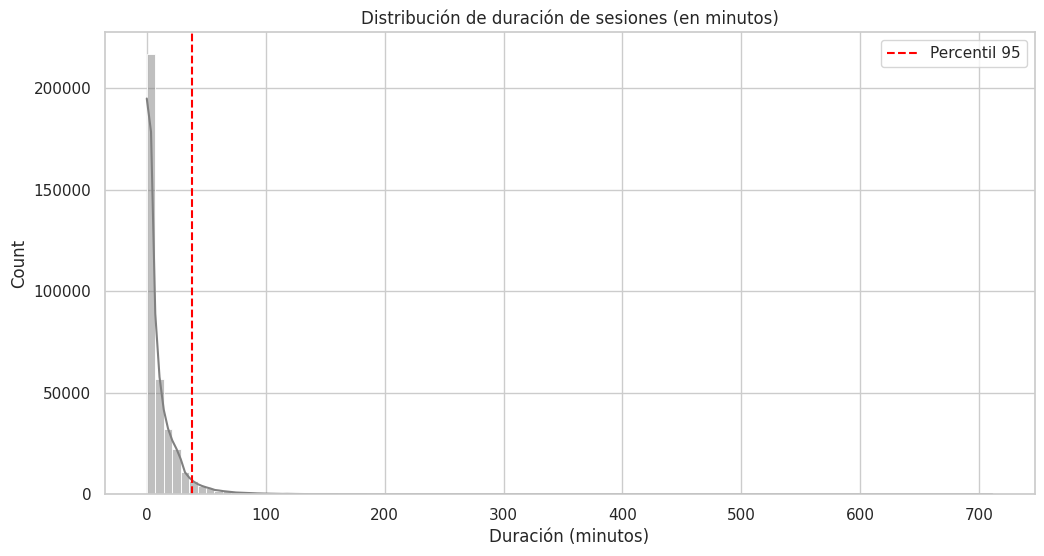

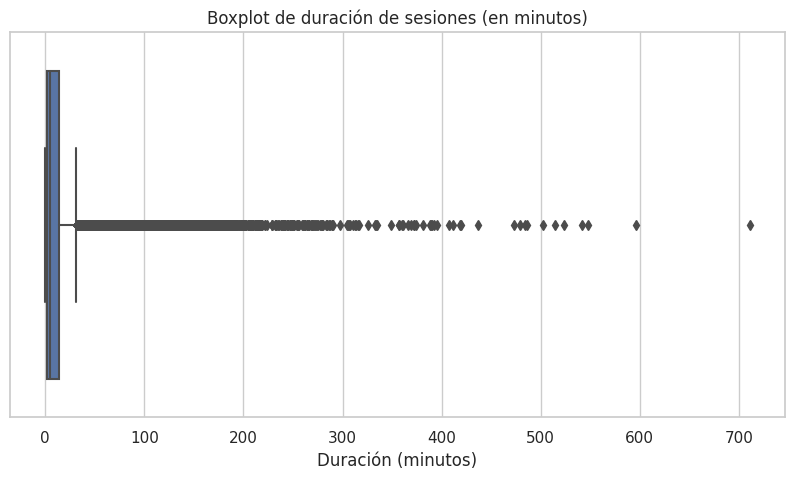


Estadísticas del 5% superior de duración:
count    17697.000000
mean      3803.932870
std       2073.288198
min       2340.000000
25%       2640.000000
50%       3180.000000
75%       4140.000000
max      42660.000000
Name: duration, dtype: float64


In [3]:
# Análisis de las sesiones largas (top 5%)
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular el percentil 95
threshold = visits['duration'].quantile(0.95)

# Dividir en dos grupos
long_sessions = visits[visits['duration'] > threshold]
normal_sessions = visits[visits['duration'] <= threshold]

# Imprimir información básica
print(f"Duración máxima total: {visits['duration'].max() / 3600:.2f} horas")
print(f"Duración media (total): {visits['duration'].mean() / 60:.2f} minutos")
print(f"Umbral del percentil 95: {threshold / 60:.2f} minutos")
print(f"Cantidad de sesiones largas: {len(long_sessions)}")
print(f"Porcentaje de sesiones largas: {(len(long_sessions) / len(visits)) * 100:.2f}%")

# Gráficos comparativos
plt.figure(figsize=(12,6))
sns.histplot(visits['duration'] / 60, bins=100, color='gray', kde=True)
plt.axvline(threshold / 60, color='red', linestyle='--', label='Percentil 95')
plt.title('Distribución de duración de sesiones (en minutos)')
plt.xlabel('Duración (minutos)')
plt.legend()
plt.show()

# Boxplot para visualizar outliers
plt.figure(figsize=(10,5))
sns.boxplot(x=visits['duration'] / 60)
plt.title('Boxplot de duración de sesiones (en minutos)')
plt.xlabel('Duración (minutos)')
plt.show()

# Estadísticas del 5% superior
print("\nEstadísticas del 5% superior de duración:")
print(long_sessions['duration'].describe())


Deducciones del análisis: 

- ¿Qué indica esto?

La media es de 63 minutos, lo cual ya es inusualmente largo para una sesión de navegación normal.

Hay usuarios con casi 12 horas de sesión, lo cual sugiere:

- probablemente dejaron la página abierta

- hay errores en la recolección de datos

El 75% de estas sesiones duró menos de 70 minutos, lo que parece más normal, pero aún elevado para un sitio comercial.

La alta desviación estándar (34 minutos) indica mucha variación en este grupo.

- Conclusión: 

Para el análisis de duración de sesiones, se realizó una revisión del 5% superior (top 5%) de los valores. Se observó que estas sesiones presentan una duración media de 63 minutos, con un máximo cercano a las 12 horas. Dado que estos valores no representan el comportamiento típico y podrían deberse a sesiones abandonadas o errores en el registro, se decidió excluir este 5% para evitar distorsiones en las métricas generales del análisis de uso. Este filtrado busca mantener el enfoque en el usuario promedio sin sesgar los resultados por valores atípicos.

#### Limpieza

In [4]:
# Eliminar duplicados manteniendo solo la primera visita por usuario y timestamp
visits = visits.drop_duplicates(subset=['Uid', 'Start Ts'])
orders = orders.drop_duplicates(subset=['Uid', 'Buy Ts'])

# Explicación para filtrar el percentil 95 (agregar comentario)
"""
Justificación: 
- El 5% superior de duraciones (>16.7 horas) pueden ser sesiones abandonadas.
- Se mantienen para análisis separado de usuarios comprometidos.
"""
duration_threshold = visits['duration'].quantile(0.95)
visits_filtered = visits[visits['duration'] <= duration_threshold].copy()

## Análisis de Métricas

### Comportamiento de usuarios (Visitas)

Tabla de Sesiones Diarias
Start Ts
2017-06-01    664
2017-06-02    658
2017-06-03    477
2017-06-04    510
2017-06-05    893
Freq: D, dtype: int64


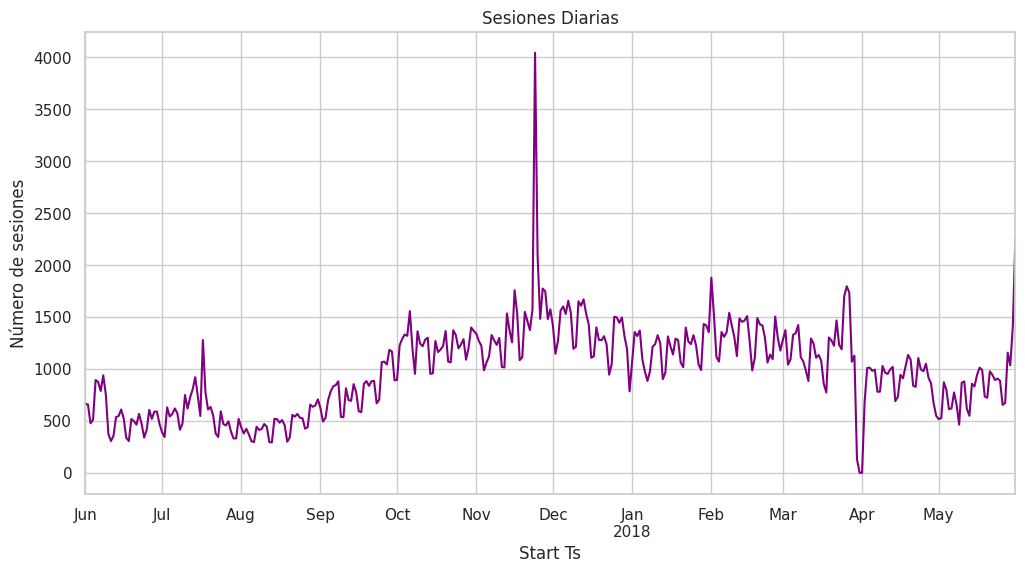

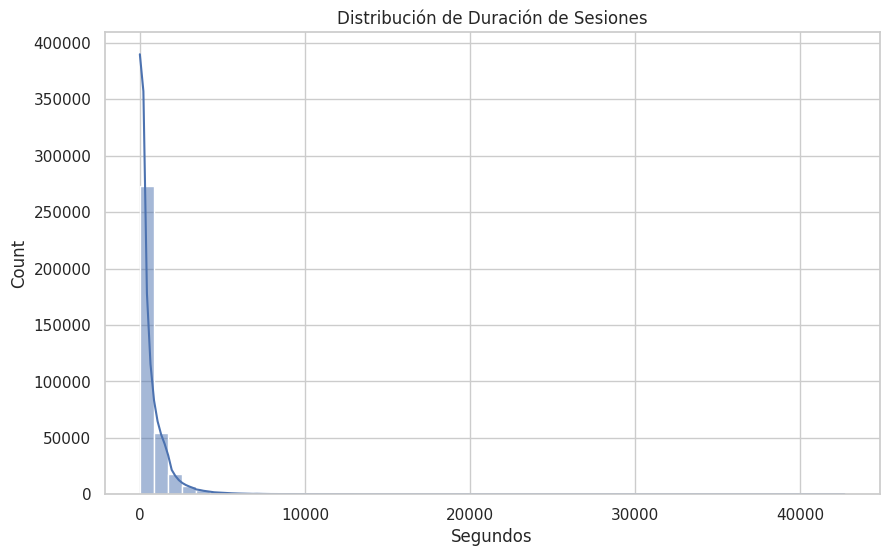

Tabla DAU (Usuarios únicos diarios)
Start Ts
2017-06-01    605
2017-06-02    608
2017-06-03    445
2017-06-04    476
2017-06-05    820
Freq: D, Name: Uid, dtype: int64
Tabla WAU (Usuarios únicos semanales)
Start Ts
2017-06-04    2021
2017-06-11    4129
2017-06-18    2812
2017-06-25    2878
2017-07-02    3064
Freq: W-SUN, Name: Uid, dtype: int64
Tabla MAU (Usuarios únicos mensuales)
Start Ts
2017-06-30    13259
2017-07-31    14183
2017-08-31    11631
2017-09-30    18975
2017-10-31    29692
Freq: M, Name: Uid, dtype: int64
Tabla Sticky Factor Semanal (DAU/WAU)
Start Ts
2017-06-04    26.397823
2017-06-11    15.641975
2017-06-18    15.266206
2017-06-25    15.238757
2017-07-02    15.297464
Freq: W-SUN, Name: Uid, dtype: float64
Tabla Sticky Factor Mensual (DAU/MAU)
Start Ts
2017-06-30    3.851472
2017-07-31    3.751424
2017-08-31    3.725028
2017-09-30    3.894949
2017-10-31    3.817038
Freq: M, Name: Uid, dtype: float64


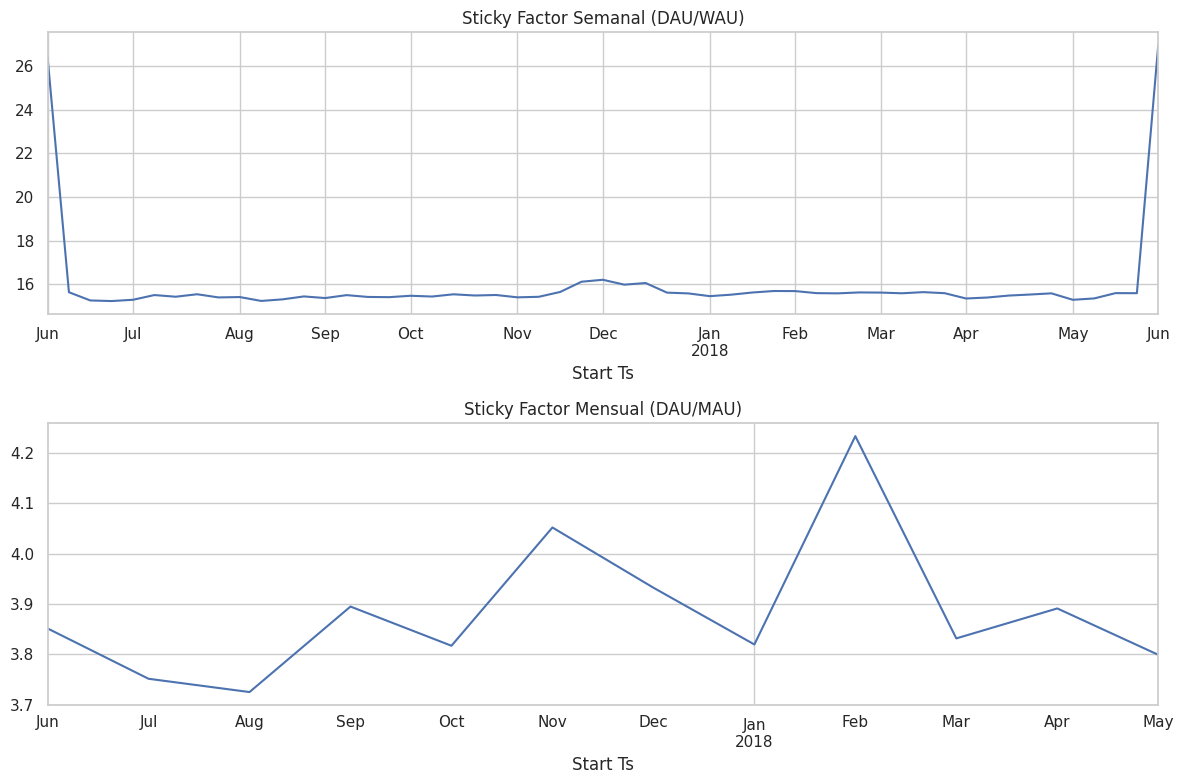

In [5]:
# Gráfico de sesiones diarias
sessions_daily = visits.resample('D', on='Start Ts').size()
print("Tabla de Sesiones Diarias")
print(sessions_daily.head())  # Mostrar las primeras filas de la tabla

plt.figure(figsize=(12,6))
sessions_daily.plot(title='Sesiones Diarias', color='purple')
plt.ylabel('Número de sesiones')
plt.show()

# Histograma de duración de sesiones
plt.figure(figsize=(10,6))
sns.histplot(visits['duration'], bins=50, kde=True)
plt.title('Distribución de Duración de Sesiones')
plt.xlabel('Segundos')
plt.show()

# Sticky Factor (DAU/WAU y DAU/MAU)
dau_series = visits.resample('D', on='Start Ts')['Uid'].nunique()
wau_series = visits.resample('W', on='Start Ts')['Uid'].nunique()
mau_series = visits.resample('M', on='Start Ts')['Uid'].nunique()

# Mostrar tablas de DAU, WAU y MAU
print("Tabla DAU (Usuarios únicos diarios)")
print(dau_series.head())

print("Tabla WAU (Usuarios únicos semanales)")
print(wau_series.head())

print("Tabla MAU (Usuarios únicos mensuales)")
print(mau_series.head())

sticky_weekly = (dau_series.groupby(pd.Grouper(freq='W')).mean() / 
                wau_series) * 100
sticky_monthly = (dau_series.groupby(pd.Grouper(freq='M')).mean() / 
                 mau_series) * 100

# Mostrar tablas de Sticky Factor Semanal y Mensual
print("Tabla Sticky Factor Semanal (DAU/WAU)")
print(sticky_weekly.head())

print("Tabla Sticky Factor Mensual (DAU/MAU)")
print(sticky_monthly.head())

# Gráficos de Sticky Factor
fig, ax = plt.subplots(2, 1, figsize=(12,8))
sticky_weekly.plot(ax=ax[0], title='Sticky Factor Semanal (DAU/WAU)')
sticky_monthly.plot(ax=ax[1], title='Sticky Factor Mensual (DAU/MAU)')
plt.tight_layout()
plt.show()


### Conversión a ventas

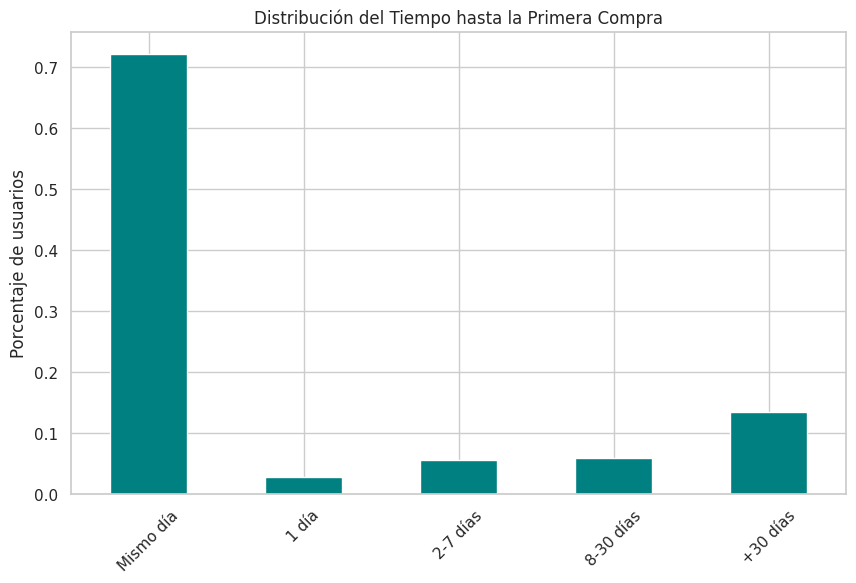

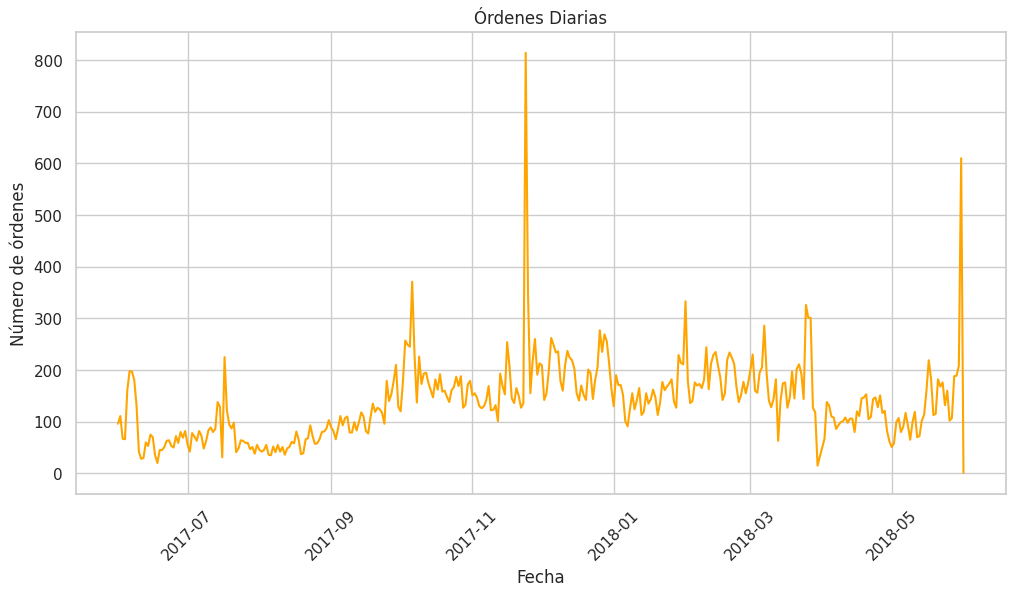

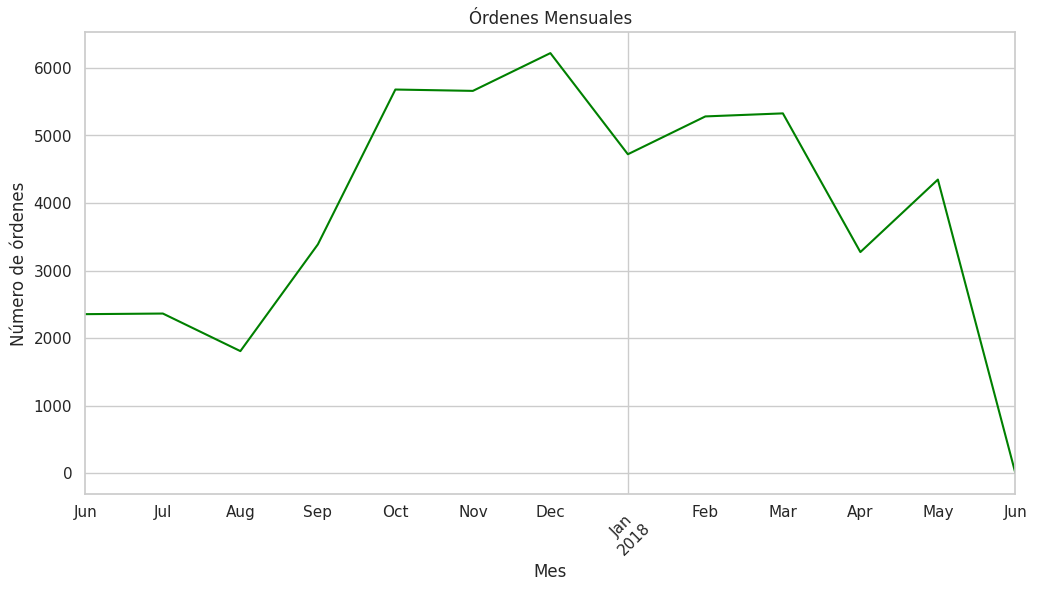

Tamaño de orden promedio: $6.90


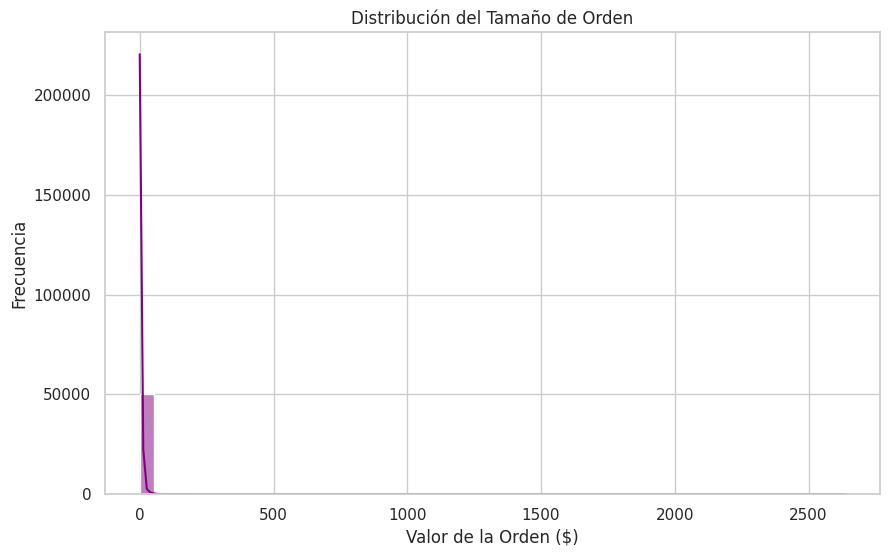

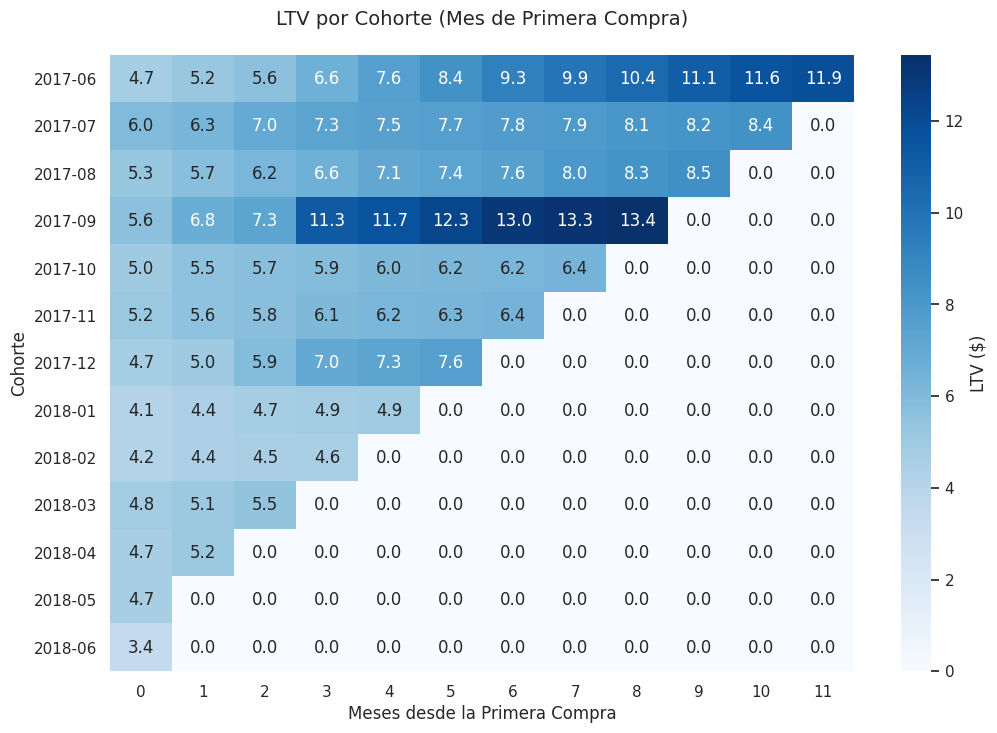

LTV promedio por cohorte de primera compra:


,LTV Promedio ($)
first_purchase_month,
2017-07,6.851992
2017-08,5.886000
2017-09,7.884075
2017-10,3.913893
2017-11,3.453541
2017-12,3.132594
2018-01,1.926526
2018-02,1.474496
2018-03,1.286146


In [6]:

# Asegurar formato datetime
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], errors='coerce')
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], errors='coerce')

# Calcular tiempo hasta primera compra
first_visit = visits.groupby('Uid')['Start Ts'].min().reset_index()
first_purchase = orders.groupby('Uid')['Buy Ts'].min().reset_index()
conversion_data = pd.merge(first_visit, first_purchase, on='Uid', how='left')

# Convertir nuevamente por seguridad
conversion_data['Start Ts'] = pd.to_datetime(conversion_data['Start Ts'], errors='coerce')
conversion_data['Buy Ts'] = pd.to_datetime(conversion_data['Buy Ts'], errors='coerce')

conversion_data['days_to_purchase'] = (conversion_data['Buy Ts'] - conversion_data['Start Ts']).dt.days

# Categorizar conversiones
bins = [-1, 0, 1, 7, 30, 1000]
labels = ['Mismo día', '1 día', '2-7 días', '8-30 días', '+30 días']
conversion_data['conversion_window'] = pd.cut(conversion_data['days_to_purchase'], bins=bins, labels=labels)

conversion_dist = conversion_data['conversion_window'].value_counts(normalize=True).sort_index()

plt.figure(figsize=(10,6))
conversion_dist.plot(kind='bar', color='teal')
plt.title('Distribución del Tiempo hasta la Primera Compra')
plt.ylabel('Porcentaje de usuarios')
plt.xticks(rotation=45)
plt.show()

# =============================================================================
# Órdenes por fecha y mes
# =============================================================================
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], errors='coerce')
orders_daily = orders.groupby(orders['Buy Ts'].dt.date).size()
orders_monthly = orders.groupby(orders['Buy Ts'].dt.to_period('M')).size()

# Graficar órdenes por día
plt.figure(figsize=(12,6))
orders_daily.plot(title='Órdenes Diarias', color='orange')
plt.ylabel('Número de órdenes')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.show()

# Graficar órdenes por mes
plt.figure(figsize=(12,6))
orders_monthly.plot(title='Órdenes Mensuales', color='green')
plt.ylabel('Número de órdenes')
plt.xlabel('Mes')
plt.xticks(rotation=45)
plt.show()

# Tamaño de orden promedio
order_avg_size = orders.groupby('Uid')['Revenue'].sum().mean()
print(f"Tamaño de orden promedio: ${order_avg_size:.2f}")

# Distribución del tamaño de orden
plt.figure(figsize=(10,6))
sns.histplot(orders['Revenue'], bins=50, kde=True, color='purple')
plt.title('Distribución del Tamaño de Orden')
plt.xlabel('Valor de la Orden ($)')
plt.ylabel('Frecuencia')
plt.show()

# =============================================================================
# Análisis LTV por cohorte
# =============================================================================

# Paso 0: Convertir 'Buy Ts' a datetime si no se ha hecho
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], errors='coerce')

# Paso 1: Primera compra de cada usuario
first_purchase = orders.groupby('Uid')['Buy Ts'].min().reset_index()
first_purchase['first_purchase_month'] = first_purchase['Buy Ts'].dt.to_period('M')

# Paso 2: Unir con todas las compras y calcular variables temporales
orders_ltv = pd.merge(
    orders,
    first_purchase[['Uid', 'first_purchase_month']],
    on='Uid',
    how='left'
)

orders_ltv['order_month'] = orders_ltv['Buy Ts'].dt.to_period('M')
orders_ltv['cohort_age'] = (orders_ltv['order_month'] - orders_ltv['first_purchase_month']).apply(lambda x: x.n)

# Paso 3: Calcular LTV
cohort_size = orders_ltv.groupby('first_purchase_month')['Uid'].nunique().reset_index(name='n_users')
ltv_table = orders_ltv.groupby(['first_purchase_month', 'cohort_age'])['Revenue'].sum().reset_index()
ltv_table = pd.merge(ltv_table, cohort_size, on='first_purchase_month')
ltv_table['ltv'] = ltv_table['Revenue'] / ltv_table['n_users']

# Paso 4: Tabla pivote y heatmap
ltv_pivot = ltv_table.pivot_table(
    index='first_purchase_month',
    columns='cohort_age',
    values='ltv',
    aggfunc='sum'
).cumsum(axis=1).fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(ltv_pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'LTV ($)'})
plt.title('LTV por Cohorte (Mes de Primera Compra)\n', fontsize=14)
plt.xlabel('Meses desde la Primera Compra', fontsize=12)
plt.ylabel('Cohorte', fontsize=12)
plt.show()

# Resultados finales
print("LTV promedio por cohorte de primera compra:")
display(ltv_pivot.mean(axis=1).tail(12).to_frame(name='LTV Promedio ($)'))


### Eficiencia de Marketing

LTV por cohorte y fuente:


,cohort,acquisition_source,total_revenue,num_users,ltv
0,2017-06,1,6392.39,190,33.644158
1,2017-06,2,3915.26,235,16.660681
2,2017-06,3,3640.32,638,5.705831
3,2017-06,4,4992.67,413,12.088789
4,2017-06,5,4377.64,384,11.400104
...,...,...,...,...,...
81,2018-05,4,3802.91,804,4.729988
82,2018-05,5,2094.04,497,4.213360
83,2018-05,9,223.05,60,3.717500
84,2018-05,10,470.89,130,3.622231


CAC por fuente:


,acquisition_source,avg_cac,total_cost
0,1,9.489732,20785.41
1,2,16.287024,42777.37
2,3,15.580474,141321.63
3,4,7.271743,61057.91
4,5,8.336731,51756.40
5,7,NaN,0.00
6,9,6.842532,4775.16
7,10,6.555415,5351.94


ROMI por fuente:


,acquisition_source,total_revenue,total_cost,romi
0,1,31090.55,20833.27,0.492351
1,2,46923.61,42806.04,0.096191
2,3,54511.24,141321.63,-0.614275
3,4,56696.83,61073.60,-0.071664
4,5,52624.02,51757.10,0.016750
5,9,5759.40,5517.49,0.043844
6,10,4450.33,5822.49,-0.235665


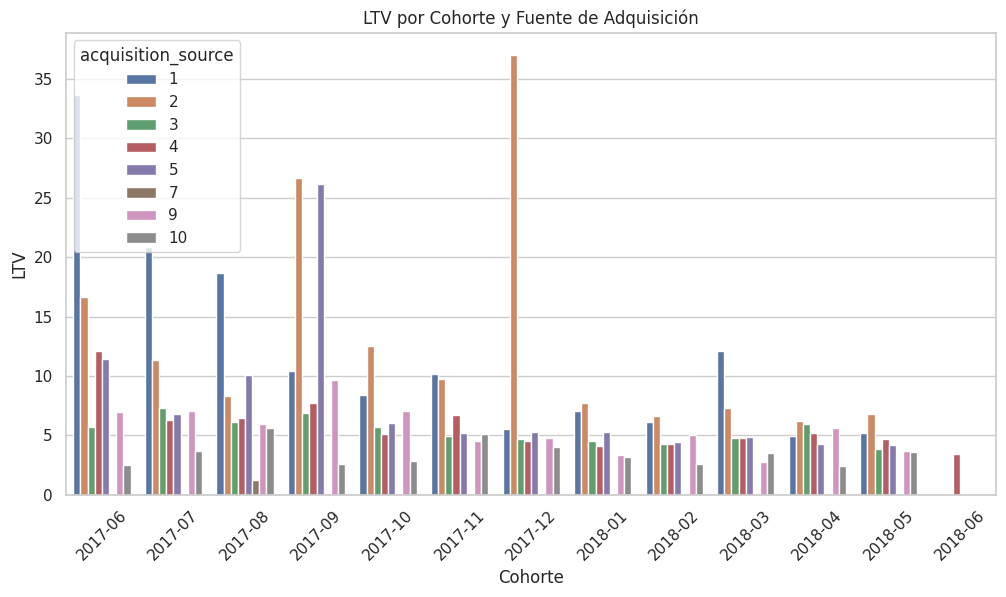

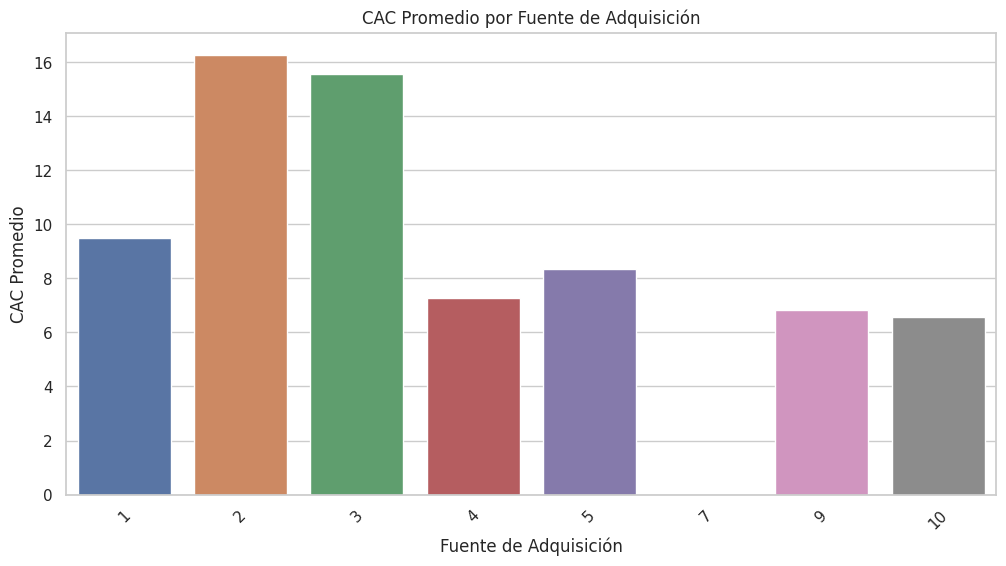

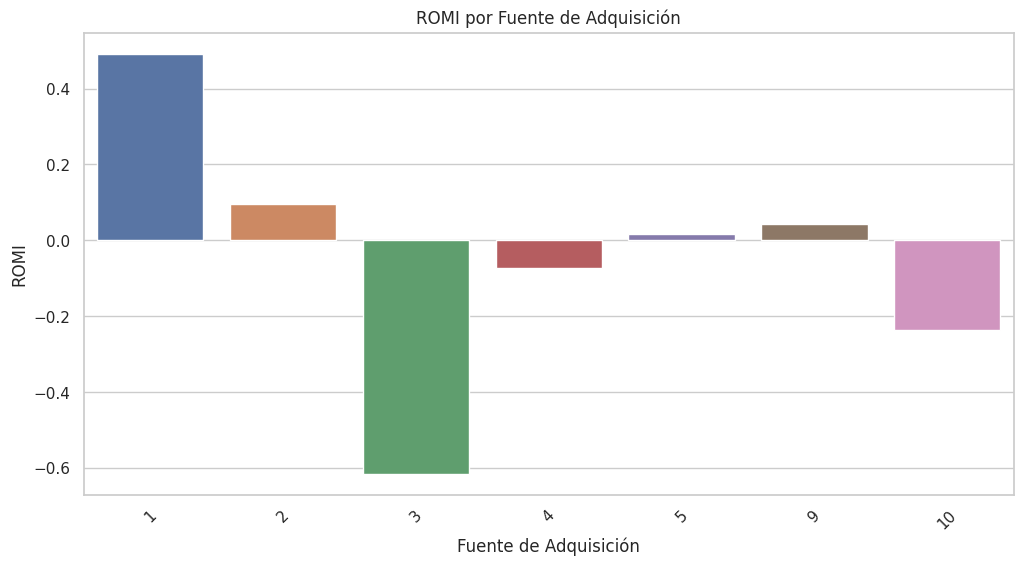

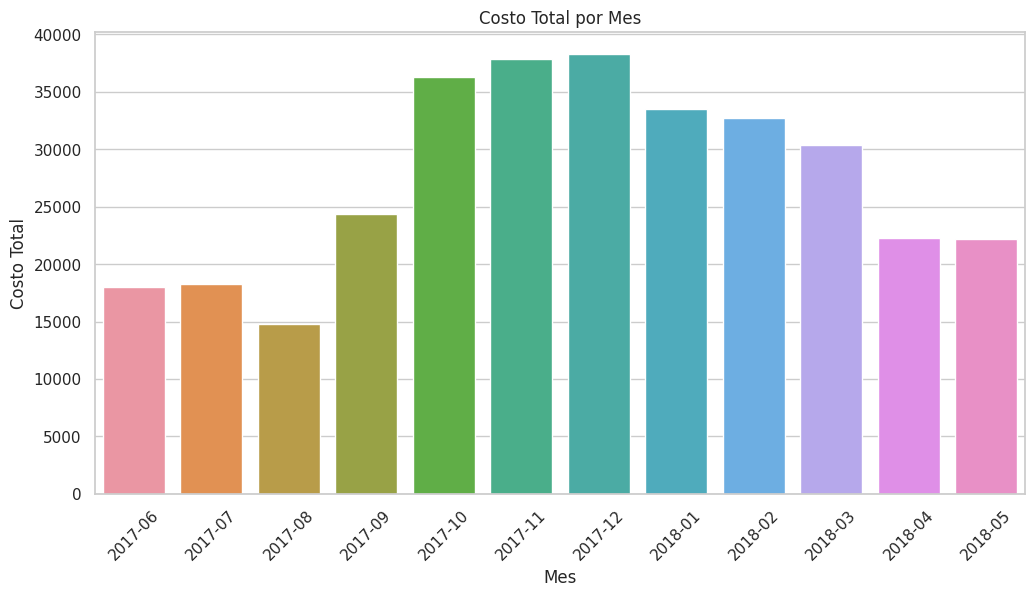

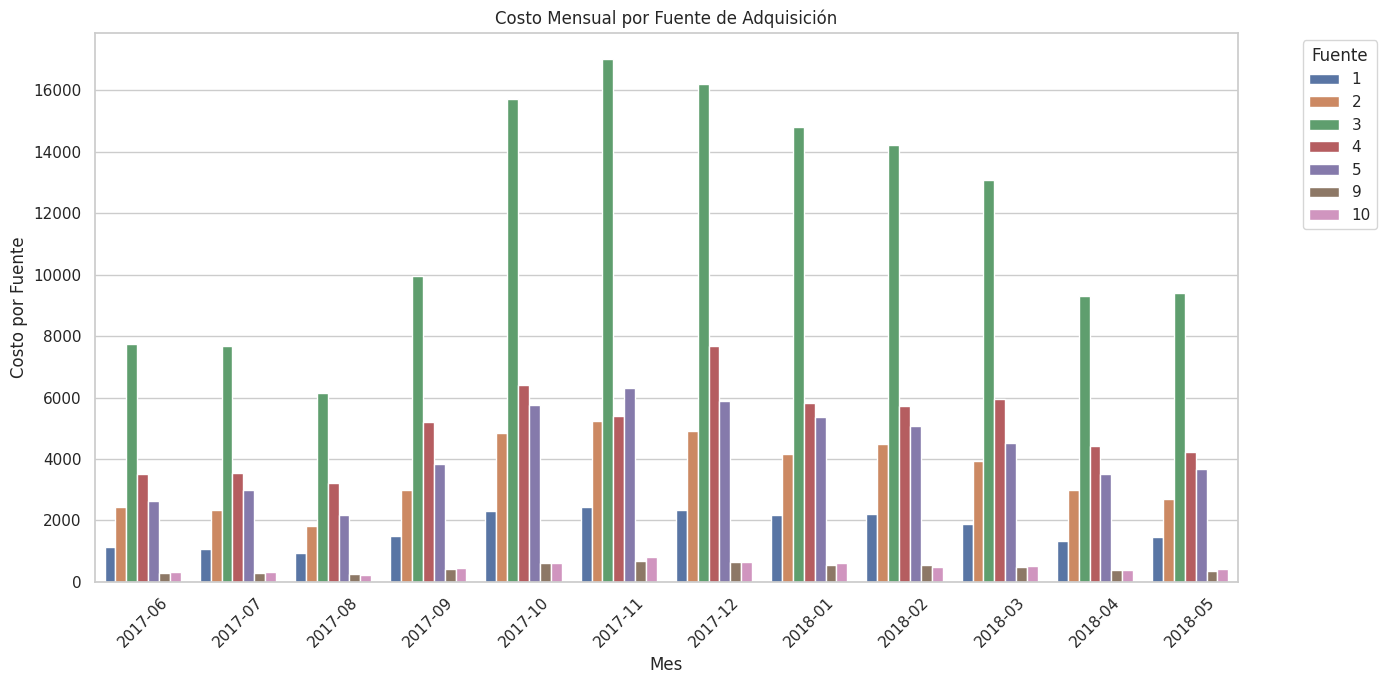

In [7]:

# Convertir columnas de fechas en cada DataFrame (si no se ha hecho previamente)
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], errors='coerce')
costs['dt']       = pd.to_datetime(costs['dt'])

# =============================================================================
# Paso 1: Fuente de adquisición de cada usuario (usando su primera visita)
# =============================================================================
first_visits = visits.sort_values(by="Start Ts").drop_duplicates(subset="Uid")
first_visits = first_visits[["Uid", "Start Ts", "Source Id"]].rename(columns={
    "Start Ts": "first_visit_ts",
    "Source Id": "acquisition_source"
})

# =============================================================================
# Paso 2: Primera compra y revenue total por usuario
# =============================================================================
first_orders = orders.groupby("Uid").agg(
    first_order_date=("Buy Ts", "min"),
    revenue=("Revenue", "sum")
).reset_index()

# =============================================================================
# Paso 3: Combinar usuarios compradores con su fuente de adquisición
# =============================================================================
buyers = first_orders.merge(first_visits, on="Uid", how="inner")

# =============================================================================
# Paso 4: Definir cohorte mensual según la fecha de primera compra
# =============================================================================
buyers["cohort"] = buyers["first_order_date"].dt.to_period("M").astype(str)

# =============================================================================
# Paso 5: Calcular LTV por cohorte y fuente
# =============================================================================
ltv_by_source = buyers.groupby(["cohort", "acquisition_source"]).agg(
    total_revenue=("revenue", "sum"),
    num_users=("Uid", "nunique")
).reset_index()
ltv_by_source["ltv"] = ltv_by_source["total_revenue"] / ltv_by_source["num_users"]

# =============================================================================
# Paso 6: Calcular CAC por fuente
# =============================================================================
orders_with_source = orders.merge(first_visits, on="Uid", how="inner")

# Corregimos la fecha para eliminar la hora (evita errores en el groupby)
orders_with_source["first_purchase_date"] = orders_with_source["Buy Ts"].dt.normalize()

first_purchase_day = orders_with_source.groupby("Uid").agg(
    first_purchase_date=("first_purchase_date", "min"),
    acquisition_source=("acquisition_source", "first")
).reset_index()

buyers_daily = first_purchase_day.groupby(["first_purchase_date", "acquisition_source"]).agg(
    num_buyers=("Uid", "nunique")
).reset_index()

# Unimos con los costos
costs_renamed = costs.rename(columns={"dt": "event_date", "source_id": "acquisition_source"})
costs_renamed["event_date"] = costs_renamed["event_date"].dt.normalize()

buyers_daily["first_purchase_date"] = pd.to_datetime(buyers_daily["first_purchase_date"]).dt.normalize()

cac_df = buyers_daily.merge(
    costs_renamed,
    left_on=["first_purchase_date", "acquisition_source"],
    right_on=["event_date", "acquisition_source"],
    how="left"
)

# CAC Diario y Promedio
cac_df["cac_daily"] = cac_df["costs"] / cac_df["num_buyers"]
cac_by_source = cac_df.groupby("acquisition_source").agg(
    avg_cac=("cac_daily", "mean"),
    total_cost=("costs", "sum")
).reset_index()

# =============================================================================
# Paso 7: Calcular ROMI correctamente
# =============================================================================
revenue_by_source = buyers.groupby("acquisition_source").agg(
    total_revenue=("revenue", "sum")
).reset_index()

# Unimos directamente con la data de costos renombrada (no usando cac_df)
costs_total_by_source = costs_renamed.groupby("acquisition_source").agg(
    total_cost=("costs", "sum")
).reset_index()

romi_df = revenue_by_source.merge(costs_total_by_source, on="acquisition_source", how="inner")
romi_df["romi"] = (romi_df["total_revenue"] / romi_df["total_cost"]) - 1

# =============================================================================
# Paso 8: Costos Totales por Mes y por Fuente (nuevo requerimiento)
# =============================================================================
costs_renamed["month"] = costs_renamed["event_date"].dt.to_period("M").astype(str)

# Costo total por mes
monthly_costs = costs_renamed.groupby("month").agg(
    total_cost=("costs", "sum")
).reset_index()

# Costo mensual por fuente
monthly_costs_by_source = costs_renamed.groupby(["month", "acquisition_source"]).agg(
    total_cost=("costs", "sum")
).reset_index()

# =============================================================================
# Mostrar resultados y gráficos
# =============================================================================
print("LTV por cohorte y fuente:")
display(ltv_by_source)

print("CAC por fuente:")
display(cac_by_source)

print("ROMI por fuente:")
display(romi_df)

sns.set(style="whitegrid")

# Gráfico de LTV
plt.figure(figsize=(12, 6))
sns.barplot(x="cohort", y="ltv", hue="acquisition_source", data=ltv_by_source)
plt.title("LTV por Cohorte y Fuente de Adquisición")
plt.xlabel("Cohorte")
plt.ylabel("LTV")
plt.xticks(rotation=45)
plt.show()

# Gráfico de CAC
plt.figure(figsize=(12, 6))
sns.barplot(x="acquisition_source", y="avg_cac", data=cac_by_source)
plt.title("CAC Promedio por Fuente de Adquisición")
plt.xlabel("Fuente de Adquisición")
plt.ylabel("CAC Promedio")
plt.xticks(rotation=45)
plt.show()

# Gráfico de ROMI
plt.figure(figsize=(12, 6))
sns.barplot(x="acquisition_source", y="romi", data=romi_df)
plt.title("ROMI por Fuente de Adquisición")
plt.xlabel("Fuente de Adquisición")
plt.ylabel("ROMI")
plt.xticks(rotation=45)
plt.show()

# Gráfico: Costo total por mes
plt.figure(figsize=(12, 6))
sns.barplot(x="month", y="total_cost", data=monthly_costs)
plt.title("Costo Total por Mes")
plt.xlabel("Mes")
plt.ylabel("Costo Total")
plt.xticks(rotation=45)
plt.show()

# Gráfico: Costo mensual por fuente
plt.figure(figsize=(14, 7))
sns.barplot(x="month", y="total_cost", hue="acquisition_source", data=monthly_costs_by_source)
plt.title("Costo Mensual por Fuente de Adquisición")
plt.xlabel("Mes")
plt.ylabel("Costo por Fuente")
plt.xticks(rotation=45)
plt.legend(title="Fuente", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Conclusiones y Recomendaciones


# Conclusiones clave:

 1. El LTV varía mucho entre fuentes
Fuente 1 tiene el LTV más alto en muchas cohortes (por ejemplo, en junio 2017, su LTV es 33.64), lo que indica que los usuarios adquiridos por esta fuente generan más ingresos por persona.

Fuente 3, aunque tiene muchos usuarios, muestra un LTV bajo (5.70), lo cual sugiere que atrae usuarios menos rentables.

 2. El CAC varía considerablemente
Fuente 3 tiene el CAC más alto (15.58) y un ROMI negativo, lo que significa que se está gastando mucho para adquirir usuarios que no generan suficiente retorno.

Fuente 1 y 4 tienen CACs más bajos (9.48 y 7.27 respectivamente) y un mejor desempeño en ROMI, aunque aún no óptimo.

 3. ROMI revela el verdadero valor
Solo Fuente 1 tiene un ROMI positivo destacado (+49.2%), lo cual indica que sí está generando ganancias después de cubrir el costo de adquisición.

Fuentes 2, 5, 9 y 10 apenas alcanzan o están cerca del punto de equilibrio.

Fuente 3 tiene un ROMI muy negativo (-61.4%), indicando una mala inversión en marketing para esa fuente.

# Recomendaciones basadas en los datos:

Invertir más en Fuente 1, ya que genera el mejor retorno y alto LTV.

Evaluar y posiblemente reducir inversión en Fuente 3, dado su CAC alto y ROMI negativo.

Monitorear de cerca a Fuente 4 y 5, que están cerca del punto de equilibrio.

Analizar el contenido y campañas de Fuente 2, que aunque genera ingresos, su CAC es alto y su ROMI apenas positivo.

Investigar más sobre Fuente 7, ya que no tiene datos suficientes y podría representar una oportunidad perdida.


